### Motivation:
Many *(?)* of scraped images do not actually depict asanas, these create noise in our labeled data. If we can strip these non-asanas out, we cn cleanup our labeled data and improve our model performance. By calculating image similarity, we can remove outlier images form our trining data. Doing so is possible via either 

    (a) human labeling (Mechanical Turk) or 
    (b) machine learning. Out of intellectual curiosity, 

I chose (b) even though (a) may be more time and cost effective.


There are three different ways we can compute image similarity [image-similarity-using-deep-ranking](https://medium.com/@akarshzingade/image-similarity-using-deep-ranking-c1bd83855978):

    (1) categorical: images are considered similar as long as they belong to the same category. This doesn't help us as we are looking to identify image similary *within* categories. 
    (2) feature extraction: Gabor filters, SIFT, Local Binary Patterns, HOG, etc. images are  considred similar if their features are similar 
    (3) Deep Ranking: learn fine-grained image similarity by characterising relationships within a set of triplets (a query image, a positive image, and a negative image)

# Housekeeping

In [70]:
import os
import glob
import sys
import cPickle as pickle

from ipywidgets import FloatProgress
import ipywidgets as widgets
from IPython.display import display
import time
import requests

import numpy as np
import pandas as pd
import os.path as path
from scipy import misc, stats
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import cv2

import pathlib

from keras.models import Sequential, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
from keras.utils import to_categorical # For keras > 2.0
from keras.callbacks import ReduceLROnPlateau


%matplotlib inline

# Pick a Class

In [10]:
# list all image files
filepaths = glob.glob('dataset/google/*/*')
filepaths = [x for x in filepaths if os.path.splitext(x)[1]!='.json']

# create dataframe of filenames
filepaths_df = pd.DataFrame({'path': filepaths,\
                            'label': [x.split('/')[2] for x in filepaths]})

asana_list = filepaths_df.label.drop_duplicates().sort_values().tolist()
asana_choice = widgets.Dropdown(description='Asana: ', options=asana_list, value=None)
asana_choice

RHJvcGRvd24oZGVzY3JpcHRpb249dSdBc2FuYTogJywgb3B0aW9ucz0oJ0FkaG8rTXVraGErU3ZhbmFzYW5hJywgJ0FkaG8rTXVraGErVnJrc2FzYW5hJywgJ0FnbmlzdGFtYmhhc2FuYScsICfigKY=


In [14]:
print asana_choice.value

Urdhva+Dhanurasana


# Load Class Images

In [21]:
filepaths_sample_df = filepaths_df[filepaths_df.label==asana_choice.value].reset_index()
max_count = filepaths_sample_df.shape[0]
print("Loading %d images for asana %s..." % (max_count,asana_choice.value))


f = FloatProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar
    
# Load the images, drop failed loads from df

images=[]
for i in range(len(filepaths_sample_df.path)):
    path = filepaths_sample_df.path[i]
    try:
        images.append(misc.imread(path))
    except:
        print "Failed to read in: %s, Dropping from dataframe" % path
        filepaths_sample_df = filepaths_sample_df.drop(i)
    f.value += 1
    
print
print("Number of images loaded: %d" %len(images))
print("Number of images in df: %d" %filepaths_sample_df.shape[0])

max_count = filepaths_sample_df.shape[0]

Loading 562 images for asana Urdhva+Dhanurasana...


FloatProgress(value=0.0, max=562.0)


Number of images loaded: 562
Number of images in df: 562


# Explore Images

dataset/google/Urdhva+Dhanurasana/Scrapper_284.jpg


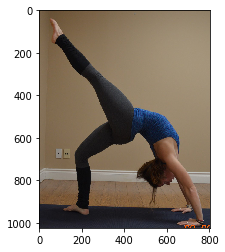

In [32]:
i=random.randint(0, max_count)
print filepaths_sample_df.path[i]
plt.imshow(images[i])

# Deep Ranking - VGG

[http://blog.ethanrosenthal.com/2016/12/05/recasketch-keras/](http://blog.ethanrosenthal.com/2016/12/05/recasketch-keras/)

We have to do a couple of preprocessing steps before feeding an image through the VGG16 model. The images must be resized to 224 x 224, the color channels must be normalized, and an extra dimension must be added due to Keras expecting to recieve multiple models. Thankfully, Keras has built-in functions to handle most of this.

In [49]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import scipy.sparse as sp

In [38]:
rand_img = filepaths_sample_df.path[i]
img = kimage.load_img(rand_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


We can now load our model in and try feeding the image through.

In [39]:
# image_top=False removes final connected layers
model = VGG16(include_top=False, weights='imagenet')
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

58900480/58889256 [==============================] - 6s 0us/step
(1, 7, 7, 512)
(25088,)


We will later have to flatten the output of the model into a long feature vector. One thing that should be noted is the time that it takes to run a single model though the NN on a 32-core r4.8xlarge instance.

In [40]:
%%timeit -n5
pred = model.predict(x)

5 loops, best of 3: 93.4 ms per loop


In [42]:
print ("We're looking at %d seconds (%d minutes) for all %d asanas in class %s." % \
       (93.4*max_count, 93.4*max_count/60, max_count, asana_choice.value))

We're looking at 52490 seconds (874 minutes) for all 562 asanas in class Urdhva+Dhanurasana.


In [82]:
# Grab relevant filenames
get_mid = lambda x: x.split(os.path.sep)[-1].split('_')[0]
fnames = filepaths_sample_df.path

idx_to_mid = {}
batch_size = 100
min_idx = 0
max_idx = min_idx + batch_size
total_max = len(fnames)

n_dims = pred.ravel().shape[0]
px = 224

# # Initialize predictions matrix
preds = sp.lil_matrix((len(fnames), n_dims))

In [83]:
while min_idx < total_max - 1:
    t0 = time.time()
    
    X = np.zeros(((max_idx - min_idx), px, px, 3))
    
    # For each file in batch, 
    # load as row into X
    for i in range(min_idx, max_idx):
        fname = fnames[i]
        mid = get_mid(fname)
        idx_to_mid[i] = mid
        img = kimage.image.load_img(fname, target_size=(px, px))
        img_array = kimage.image.img_to_array(img)
        X[i - min_idx, :, :, :] = img_array
        if i % 200 == 0 and i != 0:
            t1 = time.time()
            print('{}: {}'.format(i, (t1 - t0) / i))
            t0 = time.time()
    max_idx = i
    t1 = time.time()
    print('{}: {}'.format(i, (t1 - t0) / i))
    
    print('Preprocess input')
    t0 = time.time()
    X = preprocess_input(X)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    print('Predicting')
    t0 = time.time()
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    
    # Place predictions inside full preds matrix.
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    min_idx = max_idx
    max_idx = np.min((max_idx + batch_size, total_max))


FloatProgress(value=0.0, max=562.0)

99: 0.0395131207476
Preprocess input
0.0450439453125
Predicting
7.14217305183


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


198: 0.0205920103824
Preprocess input
0.0447669029236
Predicting
6.96472001076
200: 0.000213240385056
297: 0.0107233973866
Preprocess input
0.0447659492493
Predicting
6.95040512085
396: 0.00847520972743
Preprocess input
0.0471711158752
Predicting
6.95364499092
400: 0.000216439962387
495: 0.00454935931196
Preprocess input
0.0473380088806
Predicting
6.92839407921
561: 0.00391050413543
Preprocess input
0.0319030284882
Predicting
4.63600897789


In [84]:
pickle.dump( preds, open( "pickles/classify_play_03_imagesimilarity/preds.p", "wb" ) )

The preds matrix consists of a single row for each image with 25,088 sparse features as columns. To calculate item-item recommendations, we must convert this feature matrix into a similarity matrix.

In [88]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

preds = preds.tocsr()
sim = cosine_similarity(preds)

Using the similarity matrix, we can reuse some old functions from previous posts to visualize some the recommendations. I've added on some HTML so that clicking on the images links out to their Sketchfab pages. Let's look at a couple!

dataset/google/Urdhva+Dhanurasana/Scrapper_292.jpg


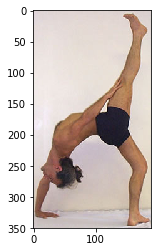

In [95]:
i=random.randint(0, max_count)
print filepaths_sample_df.path[i]
plt.imshow(images[i])

In [113]:
sim=sim; idx=100; idx_to_mid; N=20
row = sim[idx, :]
thumbs = []
mids = []
for x in np.argsort(row)[:N]:
    thumb = images[i]
    thumbs.append(thumb)
    mids.append(idx_to_mid[x])

In [114]:
print len(thumbs)
print len(mids)

20
20


In [115]:
thumbs[0].shape

(768, 1024, 3)

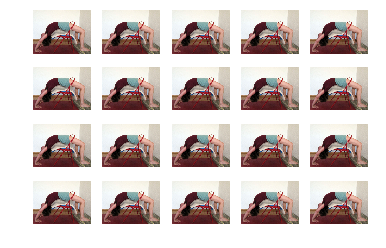

In [116]:
import PIL
%matplotlib inline

rows = 4

for num, img in enumerate(thumbs):
    plt.subplot(rows,5,num+1)
    plt.axis('off')
    plt.imshow(img)

In [73]:
sim=sim; idx=100; idx_to_mid; N=10
row = sim[idx, :]
thumbs = []
mids = []
for x in np.argsort(-row)[:N]:
    thumb = [x['url'] for x in response['thumbnails']['images']
             if x['width'] == 200 and x['height']==200]
    if not thumb:
        print('no thumbnail')
    else:
        thumb = thumb[0]
    thumbs.append(thumb)
    mids.append(idx_to_mid[x])

In [71]:
def get_thumbnails(sim, idx, idx_to_mid, N=10):
    row = sim[idx, :]
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        response = requests.get('https://sketchfab.com/i/models/{}'\
                                .format(idx_to_mid[x])).json()
        thumb = [x['url'] for x in response['thumbnails']['images']
                 if x['width'] == 200 and x['height']==200]
        if not thumb:
            print('no thumbnail')
        else:
            thumb = thumb[0]
        thumbs.append(thumb)
        mids.append(idx_to_mid[x])
    return thumbs, mids

def display_thumbs(thumbs, mids, N=5):
    thumb_html = "<a href='{}' target='_blank'>\
                  <img style='width: 160px; margin: 0px; \
                  float: left; border: 1px solid black; display:inline-block' \
                  src='{}' /></a>"
    images = "<div class='line' style='max-width: 640px; display: block;'>"

    display(HTML('<font size=5>'+'Input Model'+'</font>'))
    link = 'http://sketchfab.com/models/{}'.format(mids[0])
    url = thumbs[0]
    display(HTML(thumb_html.format(link, url)))
    display(HTML('<font size=5>'+'Similar Models'+'</font>'))

    for (url, mid) in zip(thumbs[1:N+1], mids[1:N+1]):
        link = 'http://sketchfab.com/models/{}'.format(mid)
        images += thumb_html.format(link, url)

    images += '</div>'
    display(HTML(images))
    
display_thumbs(*get_thumbnails(sim, 100, idx_to_mid, N=10), N=9)

KeyError: 'thumbnails'

In [436]:
IMG_SIZE = (100,100)
N_SAMPLE = 600 # how many to sample from each class (classes w/ <N will be dropped)
N_CLASSES = 5 # how many asanas to classify
TRAIN_TEST_SPLIT = 0.8

# DATA PREPROCESSING

71379


['dataset/google/Setu+Bandha+Sarvangasana/Scrapper_297.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_241.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_295.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_83.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_337.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_111.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_312.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_345.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_19.jpg',
 'dataset/google/Setu+Bandha+Sarvangasana/Scrapper_167.jpg']

In [442]:
# (1) Scale image arrays s.t range is between 0 and 1 instea dof 0 and 255
# (2) Resize to be of dim IMG_SIZE (width,height)
# When the normType is NORM_MINMAX, cv::normalize normalizes _src in such a way that 
#   the min value of dst is alpha and max value of dst is beta. cv::normalize does its magic 
#   using only scales and shifts (i.e. adding constants and multiplying by constants).
# (3) Drop fourth dimmension for PNG images
# (4) create 3rd dim for greay scale imges
i=random.randint(0, len(images))
print("Showing sample results for scaling/reszing of image %d, %s" % \
      (i,filepaths_sample_df.path[i]))
print
print "..... BEFORE:"
print images[i].shape
print images[i][:,:,0].shape
print stats.describe(images[i][:,:,0].flatten())
print

images_sc = [None] * len(images)
for j in range(len(images)):
    if j % 250 == 0:
        print "Processed %d images..." % j
    if images[j].all()==None:
        images_sc[j]=None
    else:
        try:
            temp = images[j]
            if len(temp.shape) > 2 and temp.shape[2] == 4: # PNG rgb images have 4 channels
                temp = cv2.cvtColor(temp, cv2.COLOR_BGRA2BGR)
            elif len(temp.shape) > 2 and temp.shape[2] == 2: # PNG grsc images have 2 channels
                temp = np.stack((temp[:,:,0],)*3, -1)
            elif len(temp.shape) == 2: # grsc images have 1 channel
                temp = np.stack((temp,)*3, -1)
            temp = cv2.resize(temp.astype('uint8'), dsize=IMG_SIZE)
            temp = cv2.normalize(temp, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, \
                                 dtype=cv2.CV_32F, dst=None)
            images_sc[j] = temp
        except:
            print "Unexpected error:", sys.exc_info()[0]

print   
print "..... AFTER:"     
print images_sc[i].shape
print images_sc[i][:,:,0].shape
print stats.describe(images_sc[i][:,:,0].flatten())

Showing sample results for scaling/reszing of image 2217, dataset/google/Svara+Yoga+Pranayama/Scrapper_445.jpg

..... BEFORE:
(283, 180, 3)
(283, 180)
DescribeResult(nobs=50940, minmax=(0, 255), mean=229.476423243031, variance=1501.5965897311469, skewness=-3.0836850610053985, kurtosis=10.807348496126243)

Processed 0 images...
Processed 250 images...
Processed 500 images...
Processed 750 images...
Processed 1000 images...
Processed 1250 images...
Processed 1500 images...
Processed 1750 images...
Processed 2000 images...
Processed 2250 images...
Processed 2500 images...
Processed 2750 images...

..... AFTER:
(100, 100, 3)
(100, 100)
DescribeResult(nobs=10000, minmax=(0.003921569, 1.0), mean=0.8987503, variance=0.022363525, skewness=-3.04746413230896, kurtosis=10.699436528348434)


In [443]:
# Split at the given index
n_images = len(images_sc)
labels = filepaths_sample_df.label.tolist()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

paths = filepaths_sample_df.path.tolist()
print("There are %d images loaded and %d labels" % \
      (n_images,len(labels)))
print

split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = np.array([images_sc[i] for i in train_indices])
y_train = np.array([dummy_y[i] for i in train_indices])
paths_train = [paths[i] for i in train_indices]
print("... of which %d are train images loaded and %d train labels" % \
      (x_train.shape[0],y_train.shape[0]))
print

x_test = np.array([images_sc[i] for i in test_indices])
y_test = np.array([dummy_y[i] for i in test_indices])
paths_test = [paths[i] for i in test_indices]
print("... of which %d train images loaded and %d train labels" % \
      (x_test.shape[0],y_test.shape[0]))

There are 2974 images loaded and 2974 labels

... of which 2379 are train images loaded and 2379 train labels

... of which 595 train images loaded and 595 train labels


dataset/google/Savasana/Scrapper_156.jpg


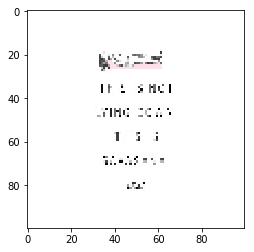

In [497]:
i=random.randint(0, x_train.shape[0])
print paths_train[i]
plt.imshow(x_train[i])


In [470]:
def visualize_data(positive_images, negative_images):
    # INPUTS
    # positive_images - Images where the label = 1 (True)
    # negative_images - Images where the label = 0 (False)

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

In [445]:
# # Number of positive and negative examples to show
# N_TO_VISUALIZE = 10

# # Select the first N positive examples
# positive_example_indices = (y_train == 1)
# positive_examples = x_train[positive_example_indices, :, :]
# positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

# # Select the first N negative examples
# negative_example_indices = (y_train == 0)
# negative_examples = x_train[negative_example_indices, :, :]
# negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

# # Call the visualization function
# visualize_data(positive_examples, negative_examples)

In [446]:
# ## MODEL CREATION ##
# # Imports
# # Model Hyperparamaters
# N_LAYERS = 4

# def cnn(size, n_layers, n_classes):
#     # INPUTS
#     # size     - size of the input images
#     # n_layers - number of layers
#     # OUTPUTS
#     # model    - compiled CNN

#     # Define model hyperparamters
#     MIN_NEURONS = 20
#     MAX_NEURONS = 120
#     KERNEL = (3, 3)

#     # Determine the # of neurons in each convolutional layer
#     steps = np.floor(MAX_NEURONS / (n_layers + 1))
#     nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
#     nuerons = nuerons.astype(np.int32)

#     # Define a model
#     model = Sequential()

#     # Add convolutional layers
#     for i in range(0, n_layers):
#         if i == 0:
#             shape = (size[0], size[1], size[2])
#             model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
#         else:
#             model.add(Conv2D(nuerons[i], KERNEL))

#         model.add(Activation('relu'))

#     # Add max pooling layer with dropout
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
# #     model.add(Dense(MAX_NEURONS))
# #     model.add(Activation('relu'))

#     # Add output layer
# #     model.add(Dense(1))
# #     model.add(Activation('sigmoid'))
#     model.add(Flatten())
#     model.add(Dense(256, activation = "relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes, activation = "softmax"))

#     # Compile the model
# #     model.compile(loss='binary_crossentropy',
# #                   optimizer='adam',
# #                   metrics=['accuracy'])
#     optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#     model.compile(optimizer = optimizer , \
#               loss = "categorical_crossentropy", \
#               metrics=["accuracy"])

#     # Print a summary of the model
#     model.summary()

#     return model

In [447]:
# Instantiate the model
image_size = x_train[0].shape
n_classes = y_train.shape[1]
# model = cnn(size=image_size, n_layers=N_LAYERS, n_classes=n_classes)

In [448]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

img_rows, img_cols = IMG_SIZE

nb_filters_1 = 32 
nb_filters_2 = 64 
nb_filters_3 = 128 

nb_conv = 3 # kernel_size dim
nb_classes = y_train.shape[1]

In [449]:
model1 = Sequential()
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = image_size))
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation = "softmax"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
__________

In [450]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model1.compile(optimizer = optimizer , \
              loss = "categorical_crossentropy", \
              metrics=["accuracy"])

In [451]:
## MODEL TRAINING ##
# Training Hyperparamters
EPOCHS = 5
BATCH_SIZE = 200

# Early stopping callback
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')

# TensorBoard callback
LOG_DIRECTORY_ROOT = 'logdir'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

# Place the callbacks in a list
callbacks = [early_stopping, tensorboard]

In [452]:
# Train the model
model1.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,\
          callbacks=callbacks, verbose=2)

Epoch 1/5
 - 59s - loss: 2.5611 - acc: 0.2114
Epoch 2/5
 - 58s - loss: 2.3321 - acc: 0.2215
Epoch 3/5
 - 58s - loss: 1.9752 - acc: 0.2215
Epoch 4/5
 - 59s - loss: 1.6849 - acc: 0.2186
Epoch 5/5
 - 58s - loss: 1.6120 - acc: 0.2182


In [526]:
# Save Model

MODEL_DIRECTORY_ROOT = 'modeldir'
model_dir = "{}/run-{}/".format(MODEL_DIRECTORY_ROOT, now)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
 
save_model(model1, model_dir+'model.h5', overwrite=True,include_optimizer=True)

In [527]:
## MODEL EVALUATION ##
# Make a prediction on the test set
test_predictions = model1.predict(x_test)
test_predictions = np.round(test_predictions)

In [528]:
print x_test.shape
print test_predictions.shape
print stats.describe(test_predictions)

(595, 100, 100, 3)
(595, 5)
DescribeResult(nobs=595, minmax=(array([0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0.], dtype=float32)), mean=array([0., 0., 0., 0., 0.], dtype=float32), variance=array([0., 0., 0., 0., 0.], dtype=float32), skewness=array([0., 0., 0., 0., 0.], dtype=float32), kurtosis=array([-3., -3., -3., -3., -3.], dtype=float32))


In [530]:
test_predictions[200]

array([0., 0., 0., 0., 0.], dtype=float32)

In [531]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


TypeError: Invalid dimensions for image data

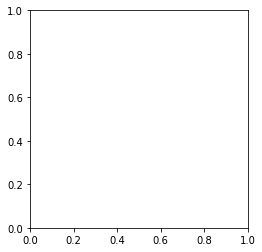

In [532]:
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())